In [ ]:
!pip install torch-snippets==0.426

     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 57 kB 7.0 MB/s 
     |████████████████████████████████| 209 kB 66.4 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch_snippets import *
from PIL import Image
#IMAGE_ROOT = 'C:/Users/WALL-E/Documents/Diplomado/Vision Artificial/Coleccion-de-imagenes-master/Coleccion-de-imagenes-master/Imagenes'
#DF_RAW = df = pd.read_csv('C:/Users/WALL-E/Documents/Diplomado/Vision Artificial/proyecto/df_raw.csv')
IMAGE_ROOT = '/content/drive/MyDrive/Vision Artificial/Data/Imagenes'
DF_RAW = df = pd.read_csv('/content/drive/MyDrive/Vision Artificial/Data/df_raw.csv')

2021-08-07 16:00:26.558 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-08-07 16:00:27.124 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
#Normalizing these coordinates means you rescale them to the 0-1 range, by dividing by the image width and height.
DF_RAW['xmin']=DF_RAW['xmin']/DF_RAW['width']
DF_RAW['xmax']=DF_RAW['xmax']/DF_RAW['width']

DF_RAW['ymin']=DF_RAW['ymin']/DF_RAW['height']
DF_RAW['ymax']=DF_RAW['ymax']/DF_RAW['height']

DF_RAW

,filename,width,height,depth,label,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,imagen_0001.png,1280,720,3,Excavadora,NaN,0,0,0.461719,0.448611,0.914062,0.787500
1,imagen_0001.png,1280,720,3,Auto,NaN,0,0,0.019531,0.661111,0.250000,0.925000
2,imagen_0002.png,1280,720,3,Excavadora,NaN,0,0,0.220312,0.252778,0.948438,0.768056
3,imagen_0003.png,1280,720,3,Excavadora,NaN,0,0,0.364844,0.322222,0.570312,0.688889
4,imagen_0004.png,1280,720,3,Excavadora,NaN,1,0,0.000781,0.043056,0.489063,0.498611
...,...,...,...,...,...,...,...,...,...,...,...,...
5502,imagen_1572.png,3840,2160,3,Camion_minero,NaN,0,0,0.538281,0.711574,0.602604,0.804167
5503,imagen_1572.png,3840,2160,3,Camion,NaN,0,0,0.067448,0.372222,0.084635,0.398148
5504,imagen_1572.png,3840,2160,3,Bulldozer,NaN,1,0,0.913802,0.849537,1.000000,0.922222
5505,imagen_1572.png,3840,2160,3,Excavadora,NaN,0,0,0.527344,0.496759,0.634115,0.701389


In [ ]:
from torch_snippets import *

df = df[df['filename'].isin(df['filename'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['label'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = os.listdir(self.image_dir)
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['filename'] == image_id]
        labels = data['label'].values.tolist()
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        return img, boxes, labels,image_id

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

In [18]:
def calculate_iou(boxA,boxB, epsilon = 1e-5):
  x1 = max(boxA[0],boxB[0])
  y1 = max(boxA[1],boxB[1])
  x2 = min(boxA[2],boxB[2])
  y2 = min(boxA[3],boxB[3])
  width = x2 - x1
  hight = y2 - y1
  if (width < 0) or (hight < 0):
    return 0.0
  area_overlap = width * hight
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b  - area_overlap
  iou = area_overlap / (area_combined + epsilon)
  return iou

In [ ]:
#image_paths = Glob(f'{IMAGE_ROOT}/images/*')
#for _ in range(1):
  #  image_id = choose(test_ds.image_infos)
 #   img_path = find(image_id, test_ds.files)
  #  original_image = Image.open(img_path, mode='r')
  #  image = preprocess_image(original_image)
  #  show(original_image,text_sz=10)
  #  show(image,text_sz=10)

In [ ]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.filename.unique(), test_size=0.1, random_state=99, shuffle=True)
trn_df, val_df = df[df['filename'].isin(trn_ids)], df[df['filename'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

2021-08-07 16:00:46.071 | INFO     | __main__:__init__:25 - 1572 items loaded
2021-08-07 16:00:46.089 | INFO     | __main__:__init__:25 - 1572 items loaded


In [ ]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels,_ = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels,_ = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [ ]:
# Cargar utils files
!gdown https://drive.google.com/uc?id=1vIN5yU7c1aQ-47JRHmGmFafjNk5-SkoP
!unzip ssd-utils-master.zip
!mv  -v /content/ssd-utils-master/* /content/

Downloading...
From: https://drive.google.com/uc?id=1vIN5yU7c1aQ-47JRHmGmFafjNk5-SkoP
To: /content/ssd-utils-master.zip
100% 12.8k/12.8k [00:00<00:00, 20.9MB/s]
Archive:  ssd-utils-master.zip
  inflating: ssd-utils-master/detect.py  
  inflating: ssd-utils-master/model.py  
  inflating: ssd-utils-master/utils.py  
renamed '/content/ssd-utils-master/detect.py' -> '/content/detect.py'
renamed '/content/ssd-utils-master/model.py' -> '/content/model.py'
renamed '/content/ssd-utils-master/utils.py' -> '/content/utils.py'


In [ ]:
# Load
import pickle
with open('/content/drive/MyDrive/Vision Artificial/models/SSD/label2targetCOPY.txt','rb') as fp:
  label2target = pickle.load(fp)
with open('/content/drive/MyDrive/Vision Artificial/models/SSD/target2labelCOPY.txt','rb') as fp:
  target2label = pickle.load(fp)

In [ ]:
model = torch.load('/content/drive/MyDrive/Vision Artificial/models/SSD/modelssdCOPY.pth')

In [ ]:
from model import SSD300, MultiBoxLoss
from detect import *

In [ ]:
n_epochs = 25

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth




Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 25.000	val_loss: 0.432	(10565.24s - 0.00s remaining)

100%|██████████| 126/126 [00:00<00:00, 176.13it/s]


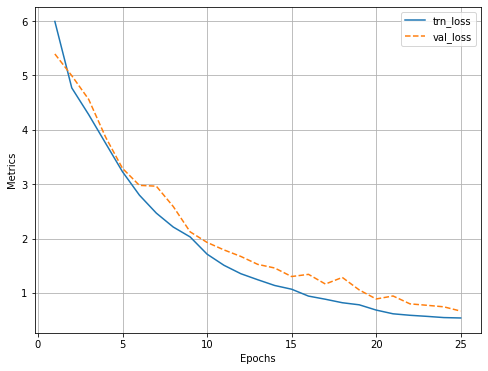

In [ ]:
log.plot_epochs('trn_loss,val_loss'.split(','))


In [ ]:
image_paths = Glob(f'{IMAGE_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

2021-08-04 17:41:17.054 | INFO     | __main__:<module>:1 - 0 files found at /content/drive/MyDrive/DIPLOMADO/Vision Artificial/Data/Imagenes/images/*


In [ ]:
image_paths = Glob(f'{IMAGE_ROOT}/images/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model, 'modelssdCOPY.pth')

In [ ]:
# save 
import pickle

with open('/content/drive/MyDrive/DIPLOMADO/Vision Artificial/models/SSD/label2targetCOPY.txt','wb') as fp:
  pickle.dump(label2target,fp)

with open('/content/drive/MyDrive/DIPLOMADO/Vision Artificial/models/SSD/target2labelCOPY.txt','wb') as fp:
  pickle.dump(target2label,fp)

In [ ]:
test_ds[]

In [ ]:
## Crea la lista de prediciones para el conjunto de prueba
pred_boxes = [] # [idx_image, class_prediction, prob_score, x1, y1, x2, y2]
true_boxes = [] # [idx_image, class, x1, y1, x2, y2]

for img, gtbbs, labels, image_id in test_ds: ##  img, gtbbs, labels, image_id
  img_path = find(image_id, test_ds.files)
  original_image = Image.open(img_path, mode='r')
  H,W,_= np.array(original_image).shape
  gtbbs = np.array(gtbbs) / np.array([300./W,300./H,300./W,300./H])
  gtbbs = gtbbs.astype(np.int32).tolist()
  pred_bbs, pred_clss, pred_confs = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
  predictions =  [[image_id,target2label[pred_cls],conf,*pred_bb ] 
                    for pred_cls, conf, pred_bb in zip( pred_clss.tolist() ,pred_confs, pred_bbs)]
  pred_boxes.extend(predictions)
  boxes = [[image_id, label, *bbs] for label, bbs in zip(labels,gtbbs)]
  true_boxes.extend(list(boxes))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from collections import Counter

def mean_average_precision(pred_boxes,true_boxes, classes,iou_threshold = 0.5):
  """
  Calculate mean average precision

  Paramenters:
      pred_boxes: list of lists containing all prediction bboxes. 
                  Each boxes is like [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
      true_boxes: Similar as pred_boxes except all the correct ones 
      iou_threshold: threshold where predicted bboxes is correct
      classes: classes

  Returns:
    float: mAP value across all classes given a specific IoU threshold
  """
  average_precisions = []
  classes_mAP = {}
  epsilon = 1e-6
  AP_table_info = pd.DataFrame([], columns = ['image','class','confidence',
                                      'iou','iou>0.5','Cum_TP','Cum_FP',
                                      'Precision','Recall'])
  for c in classes:
    detections = []
    ground_truts = []
    
    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)
    
    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truts.append(true_box)
    # amount_bboxes = {'image1':2 , 'image2':5}
    amount_bboxes = Counter([gt[0] for gt in ground_truts])
    for key , val in amount_bboxes.items():
      amount_bboxes[key] = np.zeros(val,dtype=np.int32)
    detections.sort(key = lambda x: x[2], reverse = True)
    TP = np.zeros(len(detections))
    FP = np.zeros(len(detections))
    total_true_bboxes = len(ground_truts)
    detections_ious = []
    if total_true_bboxes == 0:
      continue
    for detection_idx , deteccion in enumerate(detections):
      idx_image = deteccion[0]
      ground_truth_img = [ bbox for bbox in ground_truts if bbox[0] == idx_image]
      num_gts = len(ground_truth_img)
      best_iou = 0
      for idx, gt in enumerate(ground_truth_img):
        iou = calculate_iou(
            deteccion[3:],
            gt[2:])

        if iou > best_iou :
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:
        if isinstance(amount_bboxes[idx_image], np.ndarray) and amount_bboxes[idx_image][best_gt_idx] == 0:
          TP[detection_idx] = 1
        else:
          FP[detection_idx] = 1
      else:
        FP[detection_idx] = 1
      
      detections_ious.append([idx_image,deteccion[1],deteccion[2],best_iou, best_iou > iou_threshold ])

    TP_cumsum = np.cumsum(TP, axis = 0)
    FP_cumsum = np.cumsum(FP, axis = 0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
    # Append table info
    AP_class = [ [*_detection,TP_cum,FP_cum,precision,recall] 
                for _detection, TP_cum, FP_cum, precision, recall in zip(detections_ious,TP_cumsum,FP_cumsum,precisions,recalls)]
    AP_table_class = pd.DataFrame(AP_class, columns=AP_table_info.columns)
    AP_table_info = AP_table_info.append(AP_table_class, ignore_index = True)
    # mean precision. Area bajo la curva
    precisions = np.concatenate((np.array([1]), precisions))
    recalls = np.concatenate((np.array([0]), recalls))
    classes_mAP[c] = np.trapz(precisions, recalls)
    average_precisions.append(np.trapz(precisions, recalls))
  mAP = sum(average_precisions) / len(average_precisions)
  return mAP, classes_mAP,AP_table_info

In [ ]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precisions, recalls,ax,cls):
  ax.plot(recalls,precisions,linewidth=4, color ='red')
  ax.set_xlabel('Recall', fontsize = 12, fontweight = 'bold')
  ax.set_ylabel('Precision', fontsize = 12,fontweight = 'bold')
  ax.set_title('Precision-Recall Curve ({})'.format(cls), fontsize = 15,fontweight = 'bold')
  ax.set_ylim(bottom=0)
  ax.set_xlim(left=0)

In [19]:
classes = [ key for key in label2target.keys() if key != 'background']
classes
mAP , classes_mAP ,  AP_table_info = mean_average_precision(pred_boxes,true_boxes,classes,0.7)
print('mAP:', mAP)
classes_mAP

mAP: 0.5025533311417472


{'Auto': 0.007357461826772888,
 'Bulldozer': 0.7411459024182765,
 'Camion': 0.5728842787972408,
 'Camion_minero': 0.7759018117475255,
 'Camioneta': 0.01791761940073227,
 'Excavadora': 0.8199714998349066,
 'Otro': 0.7835403063580406,
 'Persona': 0.30170776875048255}

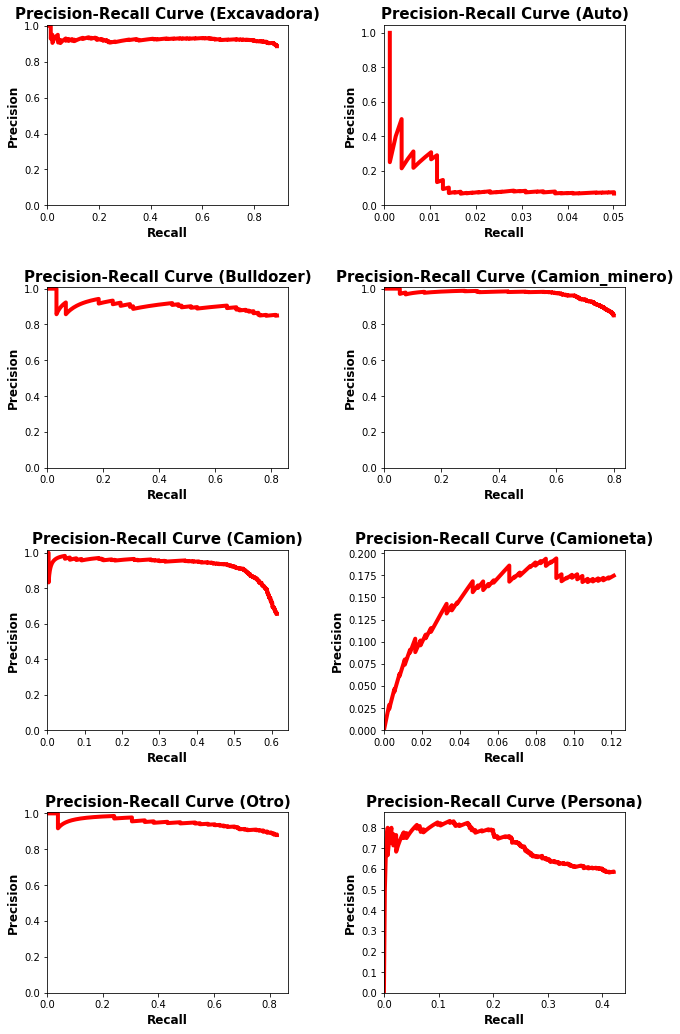

In [20]:
figure, ax = plt.subplots(int(len(classes_mAP) / 2) + len(classes_mAP) %2 , 2, figsize=(10,15))

for idx ,cls in enumerate(classes_mAP.keys()):
  AP_table_class = AP_table_info[AP_table_info['class'] == cls]
  precisions = AP_table_class['Precision'].values.tolist()
  recalls = AP_table_class['Recall'].values.tolist()
  plot_precision_recall_curve(
      precisions,recalls,
      ax=ax[int(idx /2)][idx %2],
      cls= cls)
figure.tight_layout(pad=3.0)